In [17]:
import os
import sys
import base64
import matplotlib.pyplot as plt
import numpy as np
from urllib import parse
import pandas as pd

current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, '..', '..')) 
if root_directory not in sys.path:
    sys.path.append(root_directory)

import logging
logging.basicConfig(level=logging.CRITICAL)

from code_utils.elastic import get_from_es

In [18]:
body = {
  "size": 0,
  "track_total_hits": True,
    "aggs": {
        "predicted_labels": {
        "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

In [19]:
data

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 4111493, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'predicted_labels': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'not_ipcc', 'doc_count': 4034650},
    {'key': 'ipcc', 'doc_count': 76843},
    {'key': 'ipcc_adaptation', 'doc_count': 48898},
    {'key': 'ipcc_science', 'doc_count': 15528},
    {'key': 'ipcc_mitigation', 'doc_count': 11913}]}}}

In [16]:
round(11913*100/4111493,1)

0.3

C:\Users\haallat\AppData\Local\Temp\ipykernel_5028\2461836416.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{tick:.1f}%' for tick in ax.get_yticks()], fontsize=40)


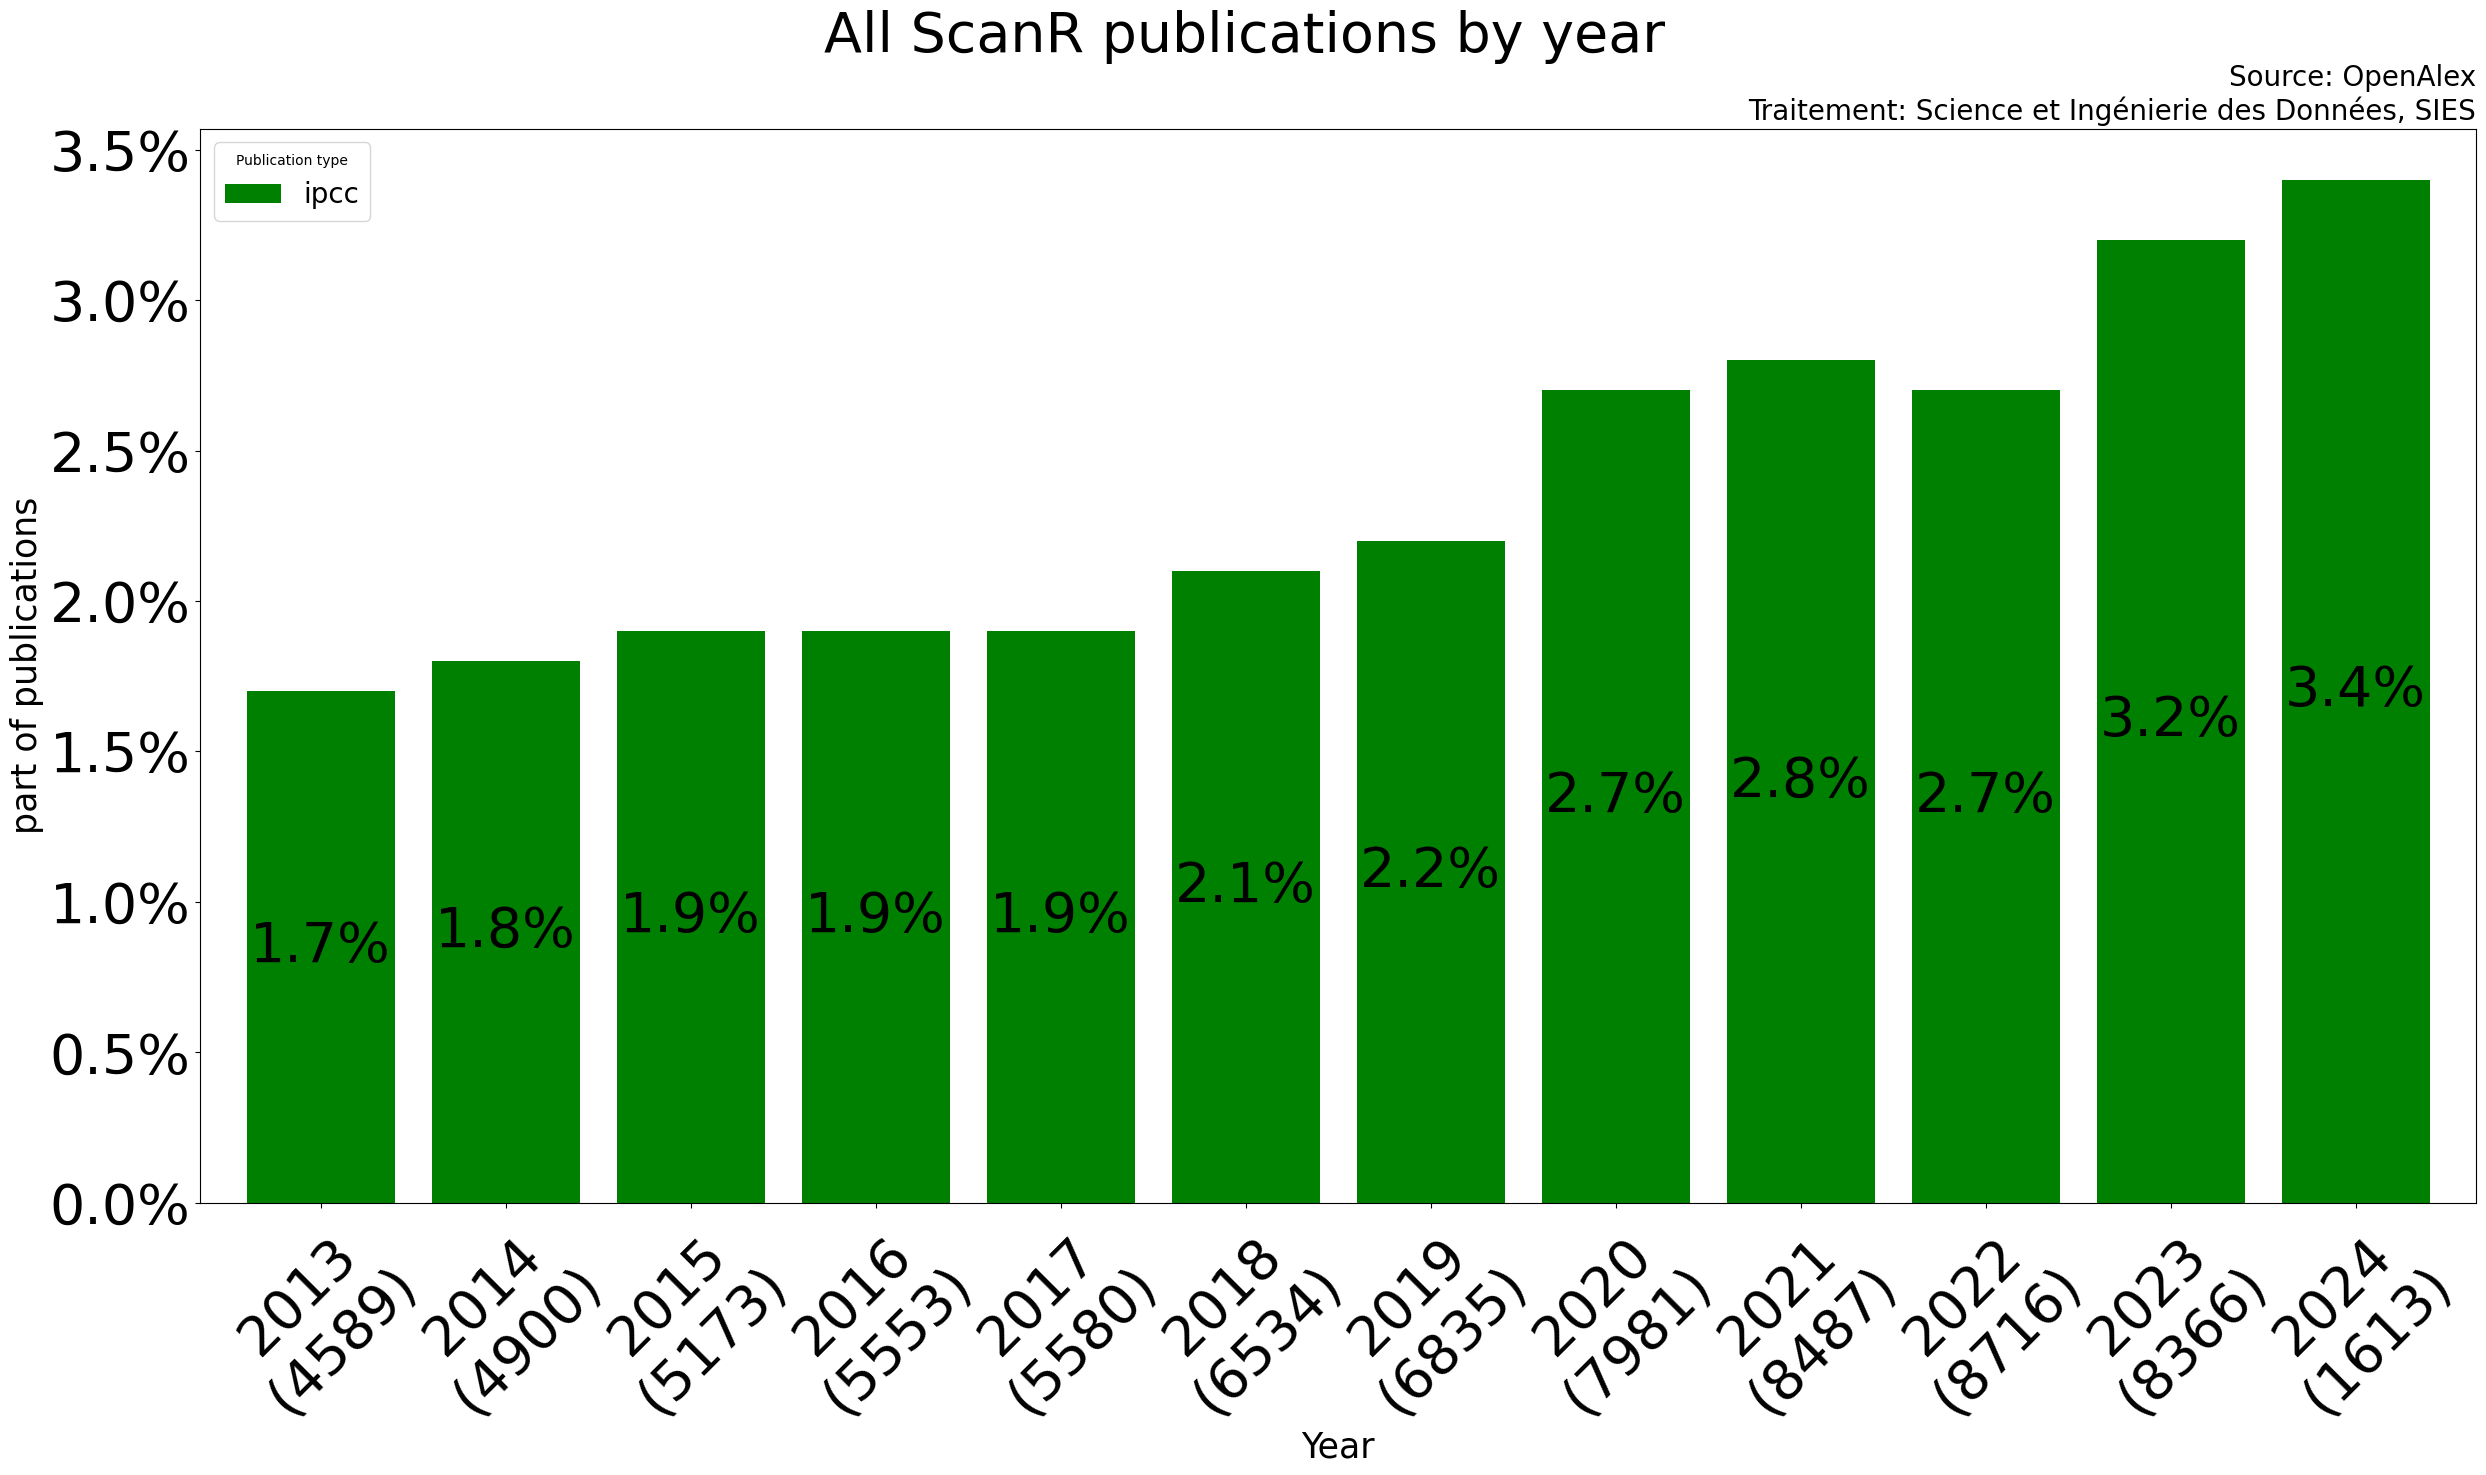

In [34]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "filter": {
       "exists": {
         "field": "year"
       }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      #data_counts[x['key']]=[]
      if 'ipcc' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc'][0]
          data_counts[x['key']]=[round(nb*100/x['doc_count'],1),int(nb)]
      else:
          data_counts[x['key']]=[0,0]
data_counts={key: value for key, value in data_counts.items() if value!= [0]}


df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc','nb'])
df = df.sort_index()

ax = df['ipcc'].plot(kind='bar', figsize=(25, 15), width=0.8, color='green')

for i, (index, row) in enumerate(df.head(20).iterrows()): 
    ax.text(i, row['ipcc'] / 2, f'{row["ipcc"]}%', ha='center', va='center', color='black', size=40)

ax.set_xlabel('Year', fontsize=25)
x_labels = [f"{df.index[:20][i]}\n({list(df.nb)[i]})" for i in range(0,12)]
ax.set_xticklabels(x_labels, rotation=45, fontsize=40)
ax.set_ylabel(f'part of publications', fontsize=25)
ax.set_yticklabels([f'{tick:.1f}%' for tick in ax.get_yticks()], fontsize=40)

ax.legend(title='Publication type', loc='upper left', fontsize=20)

plt.suptitle("All ScanR publications by year", size=40)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=20, loc='right')

plt.tight_layout()
plt.show()

C:\Users\haallat\AppData\Local\Temp\ipykernel_5028\3220658863.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{tick:.1f}%' for tick in ax.get_yticks()], fontsize=40)


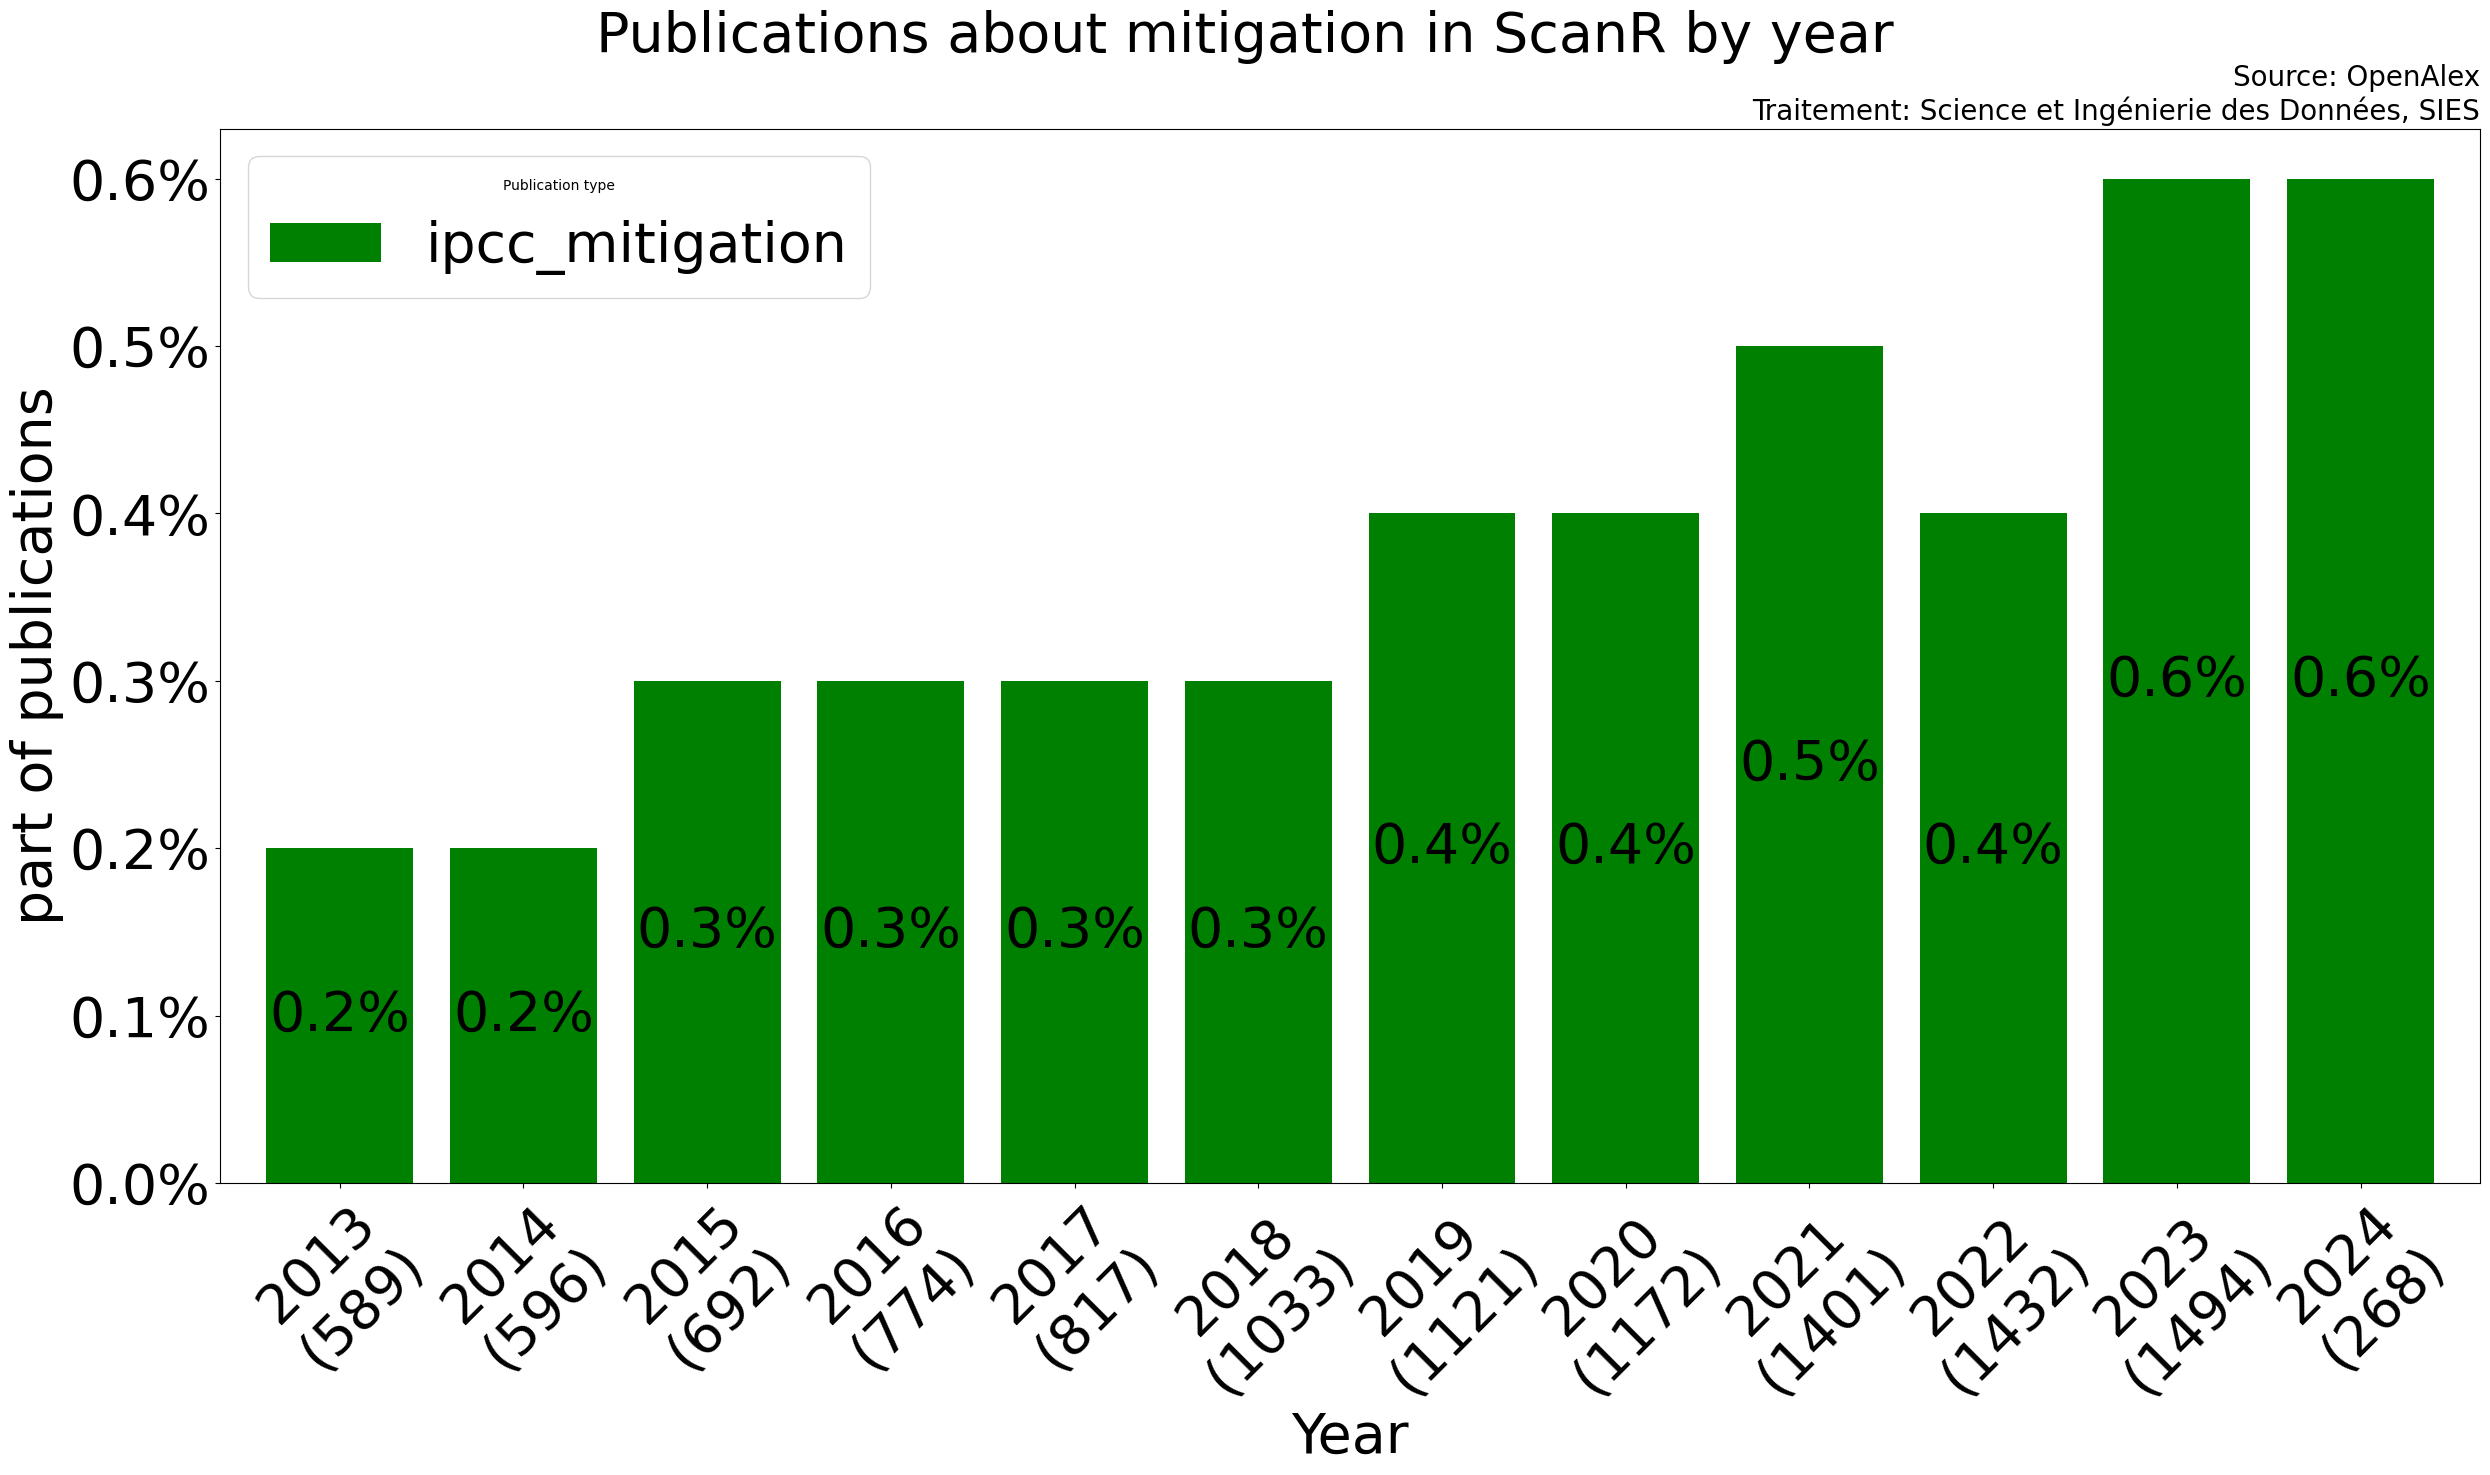

In [32]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "filter": {
       "exists": {
         "field": "year"
       }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      #data_counts[x['key']]=[]
      if 'ipcc_mitigation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_mitigation'][0]
          data_counts[x['key']]=[round(nb*100/x['doc_count'],1),int(nb)]
      else:
          data_counts[x['key']]=[0,0]
data_counts={key: value for key, value in data_counts.items() if value!= [0]}


df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_mitigation','nb'])
df = df.sort_index()

ax = df['ipcc_mitigation'].plot(kind='bar', figsize=(25, 15), width=0.8, color='green')

for i, (index, row) in enumerate(df.head(20).iterrows()): 
    ax.text(i, row['ipcc_mitigation'] / 2, f'{row["ipcc_mitigation"]}%', ha='center', va='center', color='black', size=40)

ax.set_xlabel('Year', fontsize=40)
x_labels = [f"{df.index[:20][i]}\n({list(df.nb)[i]})" for i in range(0,12)]
ax.set_xticklabels(x_labels, rotation=45, fontsize=40)
ax.set_ylabel(f'part of publications', fontsize=40)
ax.set_yticklabels([f'{tick:.1f}%' for tick in ax.get_yticks()], fontsize=40)

ax.legend(title='Publication type', loc='upper left', fontsize=40)

plt.suptitle("Publications about mitigation in ScanR by year", size=40)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=20, loc='right')

plt.tight_layout()
plt.show()

C:\Users\haallat\AppData\Local\Temp\ipykernel_17844\4257876934.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)


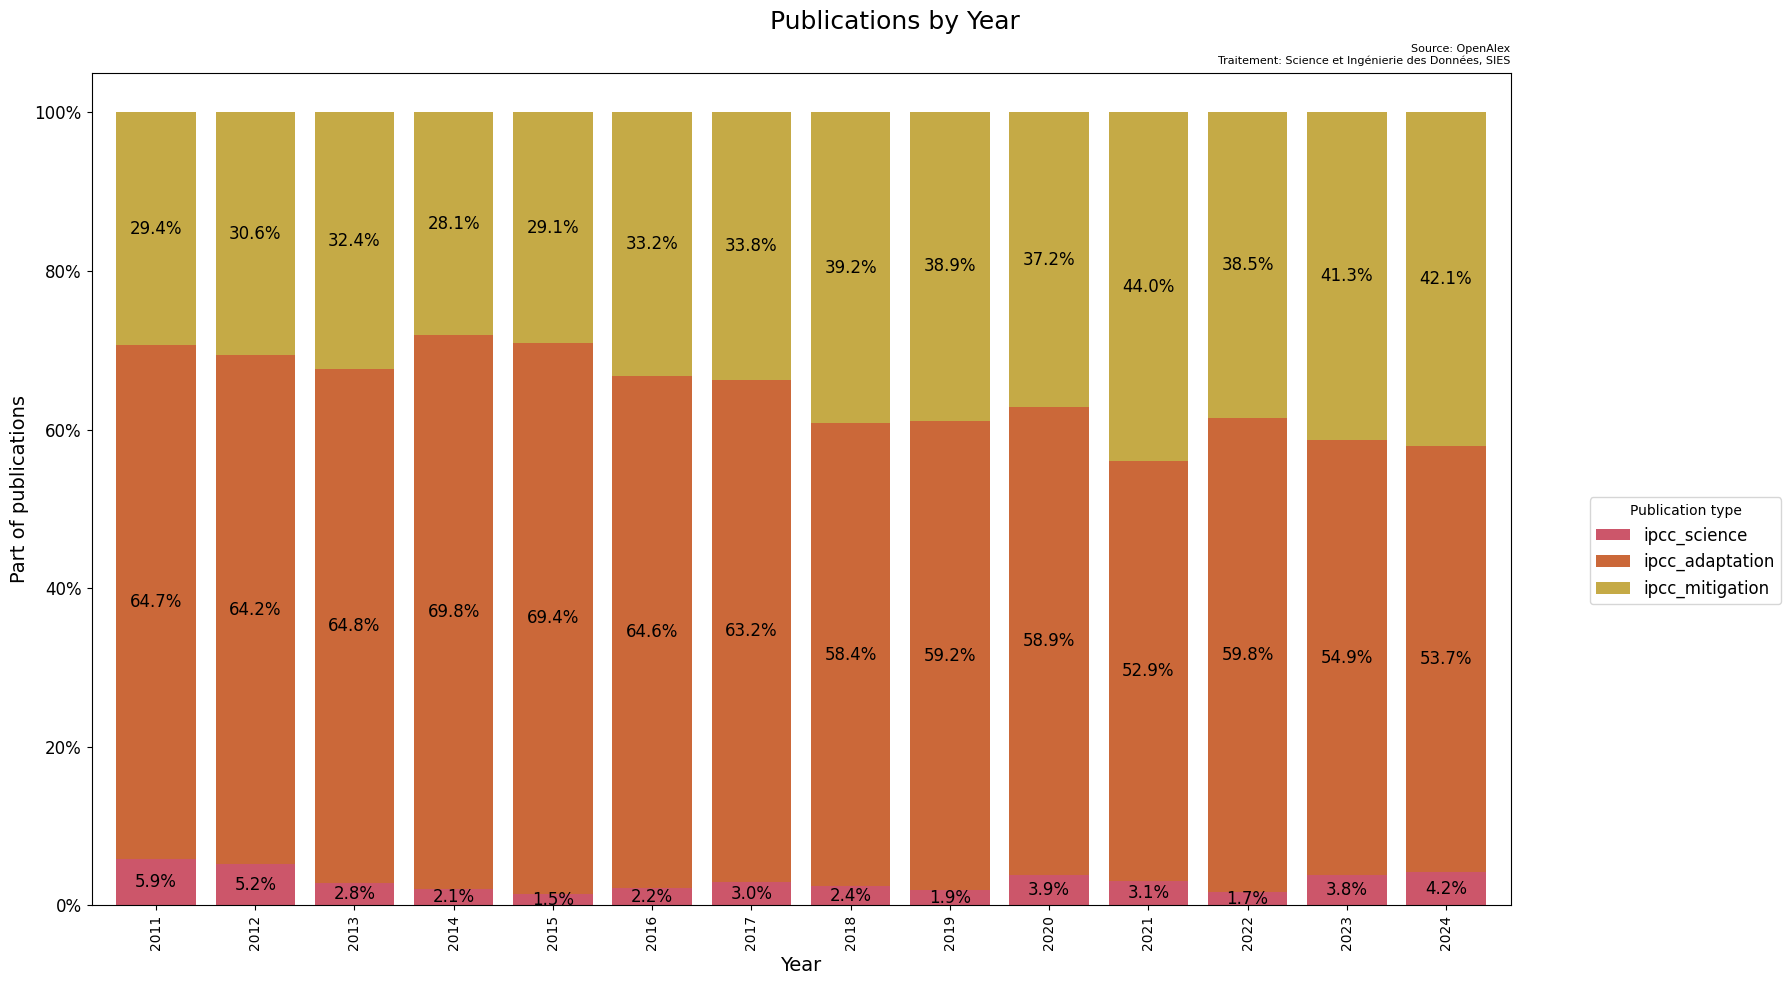

In [ ]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "must_not": {
       "exists": {
         "field": "topics"
       }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2011:
      data_counts[x['key']]=[]
      tot=sum([i['doc_count'] for i in x['predicted_labels']['buckets'] if i['key'] in ['ipcc_science', 'ipcc_adaptation','ipcc_mitigation']])
      if 'ipcc_science' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_science'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_adaptation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_adaptation'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_mitigation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_mitigation'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0, 0, 0]}
df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_science', 'ipcc_adaptation','ipcc_mitigation'])
df = df.sort_index()

list_colors=["#cc566a","#cb6839","#c5aa46","#747734","#62b055","#4bb2ac","#7377cc","#be5dae"]
ax = df.head(50).plot(kind='bar', stacked=True, figsize=(18, 10), width=0.8, color=list_colors)

for i, (index, row) in enumerate(df.head(50).iterrows()): 
    if row["ipcc_science"]!=0:
      ax.text(i, row['ipcc_science'] / 2, f'{row["ipcc_science"]}%', ha='center', va='center', color='black', size=12)
    if row["ipcc_adaptation"]!=0:
      ax.text(i, row['ipcc_science'] + row['ipcc_adaptation'] / 2, f'{row["ipcc_adaptation"]}%', ha='center', va='center', color='black', size=12)
    if row["ipcc_mitigation"]!=0:
      ax.text(i, row['ipcc_science'] + row['ipcc_adaptation'] + row['ipcc_mitigation']/ 2, f'{row["ipcc_mitigation"]}%', ha='center', va='center', color='black', size=12)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Part of publications', fontsize=14)
ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)

ax.legend(title='Publication type', bbox_to_anchor=(1.05, 0.5), loc='upper left', fontsize=12)

plt.suptitle("Publications by Year", size=18)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=8, loc='right')

plt.tight_layout()
plt.show()

top topics ipcc

In [5]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "exists": {
      "field": "topics"
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      },
      "aggs": {
        "topics": {
          "terms": {
            "field": "topics.id.keyword",
            "size": 100
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

In [4]:
names=[x['key'] for x in data['aggregations']['predicted_labels']['buckets'][1]['topics']['buckets']]

In [6]:
ids=[x['key'] for x in data['aggregations']['predicted_labels']['buckets'][1]['topics']['buckets']]

In [7]:
df1=pd.DataFrame(list(zip(ids,names)),columns=['id','name'])
df1

,id,name
0,https://openalex.org/T10029,Climate Change and Variability Research
1,https://openalex.org/T11588,Global Methane Emissions and Impacts
2,https://openalex.org/T10075,Atmospheric Aerosols and their Impacts
3,https://openalex.org/T10017,Climate Change and Paleoclimatology
4,https://openalex.org/T10644,Impacts of Climate Change on Glaciers and Wate...
...,...,...
95,https://openalex.org/T10298,Influence of Built Environment on Active Travel
96,https://openalex.org/T13377,Anticipating Critical Transitions in Ecosystems
97,https://openalex.org/T11862,Agroecology and Global Food Systems
98,https://openalex.org/T10367,Agricultural Innovation and Livelihood Diversi...


In [8]:
import requests
url="https://api.openalex.org/works?filter=has_doi:true,title_and_abstract.search:(%22climate%20change%22%20OR%20%22marine%20ecosystems%22%20OR%20%22methane%20emission%22%20OR%20%22ocean%20acidification%22%20OR%20%22arctic%20sea%20ice%22%20OR%20%22environmental%20impact%22%20OR%20%22climate%20ethics%22%20OR%20%22hydrological%20cycle%22%20OR%20%22energy%20transition%22%20OR%20%22influence%20of%20climate%22%20OR%20%22urban%20heat%20islands%22%20OR%20%22mitigation%20strategies%22%20OR%20%22impact%20on%20climate%22%20OR%20%22environmental%20policies%22%20OR%20%22carbon%20dioxide%20capture%22%20OR%20%22carbon%20dioxide%20storage%22%20OR%20%22soil%20carbon%20dynamics%22%20OR%20%22sustainable%20development%22%20OR%20%22environmental%20governance%22%20OR%20%22atmospheric%20aerosols%22%20OR%20%22marine%20biogeochemistry%22%20OR%20%22global%20flood%20risk%22%20OR%20%22arctic%20sea%20ice%22%20OR%20%22ocean%20surface%20waves%20and%20wind%20interaction%22%20OR%20%22aeolian%20geomorphology%22%20OR%20%22wind%20erosion%20dynamics%22%20OR%20%22coastal%20protection%22%20OR%20%22water%20resource%20management%22%20OR%20%22air%20pollution%22%20OR%20%22energy%20efficiency%22%20OR%20%22global%20drought%22%20OR%20%22landslide%20hazards%22%20OR%20ecology%20OR%20ecological%20OR%20environmental%20OR%20biodiversity%20OR%20deforestation%20OR%20paleoclima)&group-by=topics.id"
response = requests.get(url)
data = response.json()
df2=pd.DataFrame(data=[(x['key'],x['key_display_name']) for x in data['group_by'][:100]],columns=['id','name'])

In [20]:
df=pd.concat([df1,df2]).drop_duplicates()
df=df.reset_index()

In [22]:
df.loc[:,'id']=df.loc[:,'id'].apply(lambda x: str(x).replace('https://openalex.org/',''))

In [23]:
dict_topics=dict(zip(list(df.id),list(df.name)))

In [13]:
climat_topics=['T10753', 'T11988', 'T10122', 'T10139', 'T10577', 'T11862', 'T13377', 'T10898', 'T12981', 'T10174', 'T11405', 'T13396', 'T12213', 'T12639', 'T11056', 'T11880', 'T11753', 'T10439', 'T10766', 'T10438', 'T12806', 'T11244', 'T11186', 'T10029', 'T11588', 'T10075', 'T10017', 'T10644', 'T10895', 'T10266', 'T10230', 'T11320', 'T10341', 'T10005', 'T10347', 'T10765', 'T10032', 'T11333', 'T10226', 'T10466', 'T10647', 'T11483', 'T10330', 'T10471', 'T10199', 'T10555', 'T11259', 'T11594', 'T10643', 'T10319', 'T10487', 'T10435', 'T10659', 'T10089']

In [32]:
'T10255,T11088,T10930,T12073,T11459,T11061,T10302,T10190,T10779,T10535,T12617,T12414,T10166,T10004,T10889,T11913,T10398,T11760'.split(',')

['T10255',
 'T11088',
 'T10930',
 'T12073',
 'T11459',
 'T11061',
 'T10302',
 'T10190',
 'T10779',
 'T10535',
 'T12617',
 'T12414',
 'T10166',
 'T10004',
 'T10889',
 'T11913',
 'T10398',
 'T11760']

In [31]:
for i in range(100):
    if df.loc[:,'id'][i] not in climat_topics:
        print(i,df.loc[i,['id','name']])

11 id                                        T10255
name    Oceanic Modeling and Circulation Studies
Name: 11, dtype: object
18 id                                                 T11088
name    Impact of Aquaculture on Marine Ecosystems and...
Name: 18, dtype: object
20 id                                           T10930
name    Global Flood Risk Assessment and Management
Name: 20, dtype: object
23 id                                                 T12073
name    Application of Stable Isotopes in Trophic Ecology
Name: 23, dtype: object
26 id                                      T11459
name    Arctic Sea Ice Variability and Decline
Name: 26, dtype: object
27 id                                                 T11061
name    Dynamics of Ocean Surface Waves and Wind Inter...
Name: 27, dtype: object
28 id                                                 T10302
name    Importance and Conservation of Freshwater Biod...
Name: 28, dtype: object
30 id                               T10190
name    

In [30]:
l

['T10255',
 'T11088',
 'T10930',
 'T12073',
 'T11459',
 'T11061',
 'T10302',
 'T10190',
 'T10779',
 'T10109',
 'T10535',
 'T12383',
 'T12617',
 'T10111',
 'T10965',
 'T10332',
 'T10841',
 'T10995',
 'T10119',
 'T12414',
 'T12047',
 'T10166',
 'T11234',
 'T10004',
 'T11336',
 'T11371',
 'T10121',
 'T10889',
 'T13176',
 'T11913',
 'T10398',
 'T12492',
 'T10692',
 'T11312',
 'T11760',
 'T11791',
 'T11387',
 'T10012',
 'T10819',
 'T10969',
 'T11111',
 'T11354',
 'T11059',
 'T11796',
 'T10815',
 'T10410',
 'T12656',
 'T10747',
 'T10298',
 'T10367']

In [126]:
climat_topics[8]

'T10969'